In [1]:
library("data.table")
library("tidyverse")
library("cowplot")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [4]:
df <- fread("/nfs/research/birney/users/saul/outputs/medaka_beahviour/medaka_behaviour_pilot/hmm/time_step0.08_n_states15_hmm.csv.gz")
head(df)

id,frame_n,time_s,distance,angle,hmm_state
<chr>,<int>,<dbl>,<dbl>,<dbl>,<int>
20190611_1331_icab_icab_R_no_q1_ref,3,0.1000000,0.83681897,2.993237,11
20190611_1331_icab_icab_R_no_q1_ref,5,0.1666667,0.37884199,2.356685,11
20190611_1331_icab_icab_R_no_q1_ref,7,0.2333333,0.31815616,2.949842,14
20190611_1331_icab_icab_R_no_q1_ref,9,0.3000000,0.02669565,0.401145,14
20190611_1331_icab_icab_R_no_q1_ref,11,0.3666667,0.07495629,1.065193,14
20190611_1331_icab_icab_R_no_q1_ref,13,0.4333333,0.10567185,-3.103933,14


In [5]:
df <- df[str_detect(id, "icab_icab")]
df[, date := str_remove(id, "_.*$")]
df[, time_string := str_remove(id, sprintf("%s_", date)) |> str_remove("_.*$")]
df[, time_numeric_h := str_remove(time_string, "..$") |> as.numeric()]
df[, time_numeric_m := str_remove(time_string, "^..") |> as.numeric()]
df[, time_numeric := time_numeric_h + (time_numeric_m/60)]
df[, time_numeric_m := str_remove(time_string, "^..") |> as.numeric()]
df[, quadrant := str_remove(id, "^.*_(of|no)_") |> str_remove("_.*$")]
df[, tank_side := str_remove(id, "^.*_icab_icab_") |> str_remove("_.*$")]
df[, assay := str_remove(id, "_q.*$") |> str_remove("^.*_")]
df[, fish := str_remove(id, "^.*_")]

In [6]:
res <- df[, .(speed = mean(distance)), by = c("date", "time_numeric", "quadrant", "tank_side", "fish")]
head(res)

date,time_numeric,quadrant,tank_side,fish,speed
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
20190611,13.51667,q1,R,ref,2.426096
20190611,13.51667,q1,R,test,2.219383
20190611,13.51667,q2,R,ref,2.071570
20190611,13.51667,q2,R,test,2.301165
20190611,13.51667,q3,R,ref,2.254157
20190611,13.51667,q3,R,test,2.000584


In [7]:
fit <- aov(speed ~ date + time_numeric + quadrant + tank_side, data = res)
anova_pvals <- broom::tidy(fit) |>
    filter(term != "Residuals") |>
    mutate(p.fdr = p.adjust(p.value, method = "fdr")) |>
    rstatix::add_significance(p.col = "p.fdr") |>
    mutate(p.fdr = signif(p.fdr, 3)) |>
    mutate(
        p_final = ifelse(
            p.fdr.signif == "ns",
            paste("p =", p.fdr),
            paste("p =", p.fdr, p.fdr.signif)
        )
    ) |>
    as.data.table()

anova_pvals

term,df,sumsq,meansq,statistic,p.value,p.fdr,p.fdr.signif,p_final
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
date,4,5.4246588,1.3561647,3.3116207,0.01287099,0.0257,*,p = 0.0257 *
time_numeric,1,0.1757121,0.1757121,0.4290716,0.51363891,0.5140,ns,p = 0.514
quadrant,3,4.7248601,1.5749534,3.8458811,0.01128580,0.0257,*,p = 0.0257 *
tank_side,1,1.2980673,1.2980673,3.1697527,0.07742386,0.1030,ns,p = 0.103


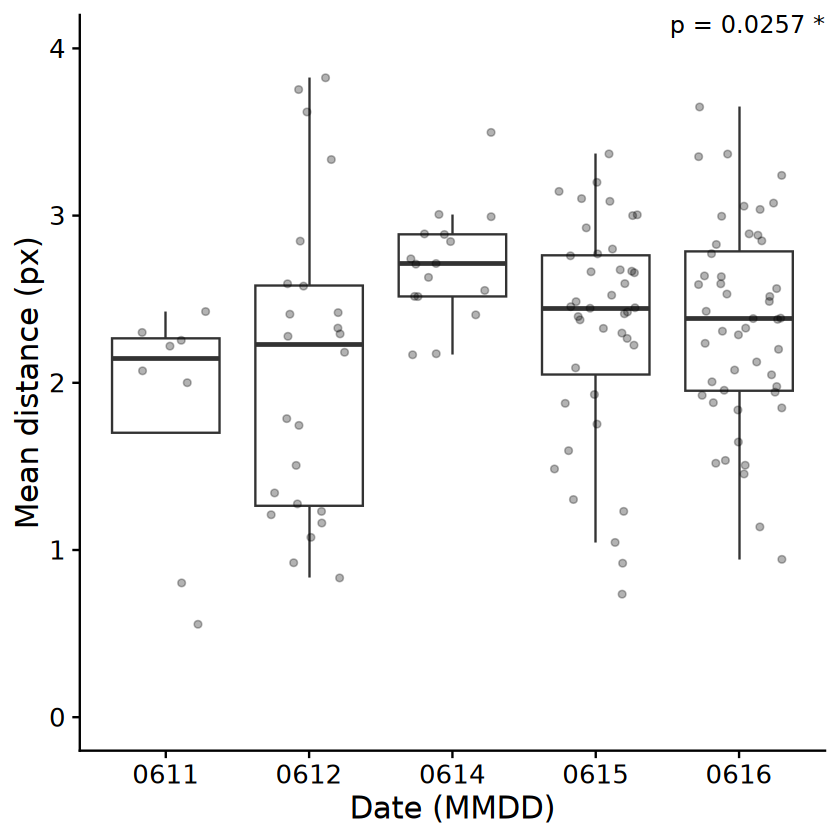

In [8]:
options(repr.plot.width = 7, repr.plot.height = 7)
p1 <- ggplot(res, aes(x = str_remove(date, "2019"), y = speed)) +
    geom_boxplot(outlier.shape =  NA) +
    geom_jitter(width = 0.3, height = 0, alpha = 0.3) + 
    theme_cowplot(18) +
    labs(x = "Date (MMDD)", y = "Mean distance (px)") +
    geom_text(data = anova_pvals[term == "date"], aes(label = p_final, x = Inf, y = Inf, hjust = 1, vjust = 1), size = 5) +
    ylim(0, 4) +
    theme(
        axis.text.x = element_text()
    )

p1

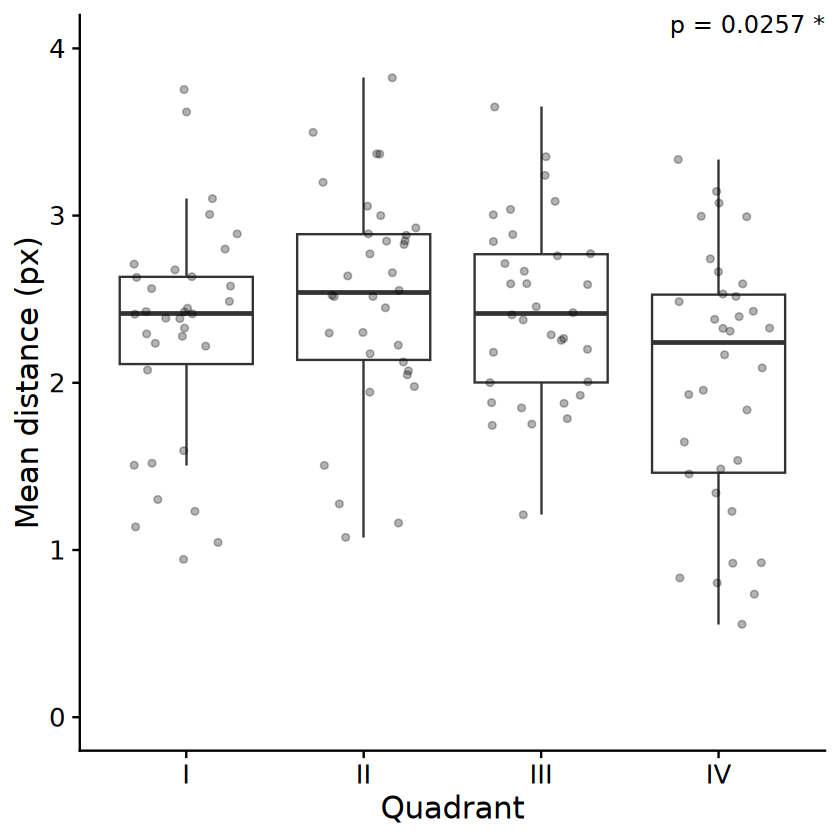

In [9]:
options(repr.plot.width = 7, repr.plot.height = 7)
p2 <- ggplot(res, aes(x = quadrant, y = speed)) +
    geom_boxplot(outlier.shape =  NA) +
    geom_jitter(width = 0.3, height = 0, alpha = 0.3) + 
    theme_cowplot(18) +
    labs(x = "Quadrant", y = "Mean distance (px)") +
    scale_x_discrete(labels = c("q1" = "I", "q2" = "II", "q3" = "III", "q4" = "IV")) +
    geom_text(data = anova_pvals[term == "quadrant"], aes(label = p_final, x = Inf, y = Inf, hjust = 1, vjust = 1), size = 5) +
    ylim(0, 4)

p2

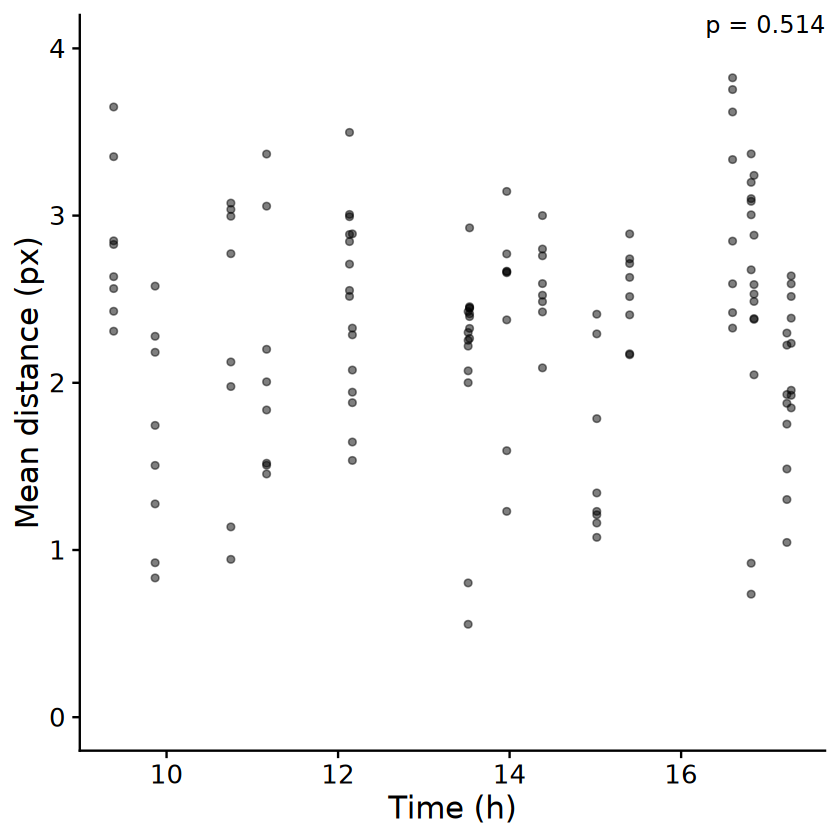

In [10]:
options(repr.plot.width = 7, repr.plot.height = 7)
p3 <- ggplot(res, aes(x = time_numeric, y = speed)) +
    geom_point(alpha = 0.5) + 
    theme_cowplot(18) +
    labs(x = "Time (h)", y = "Mean distance (px)") +
    geom_text(data = anova_pvals[term == "time_numeric"], aes(label = p_final, x = Inf, y = Inf, hjust = 1, vjust = 1), size = 5) +
    ylim(0, 4)

p3

In [16]:
time_to_hour_minute <- function(t){sprintf("%s:%s", floor(t), round(60 * (t - floor(t))))}
res[, range(time_numeric) |> time_to_hour_minute()]

[1] "9:23"  "17:17"

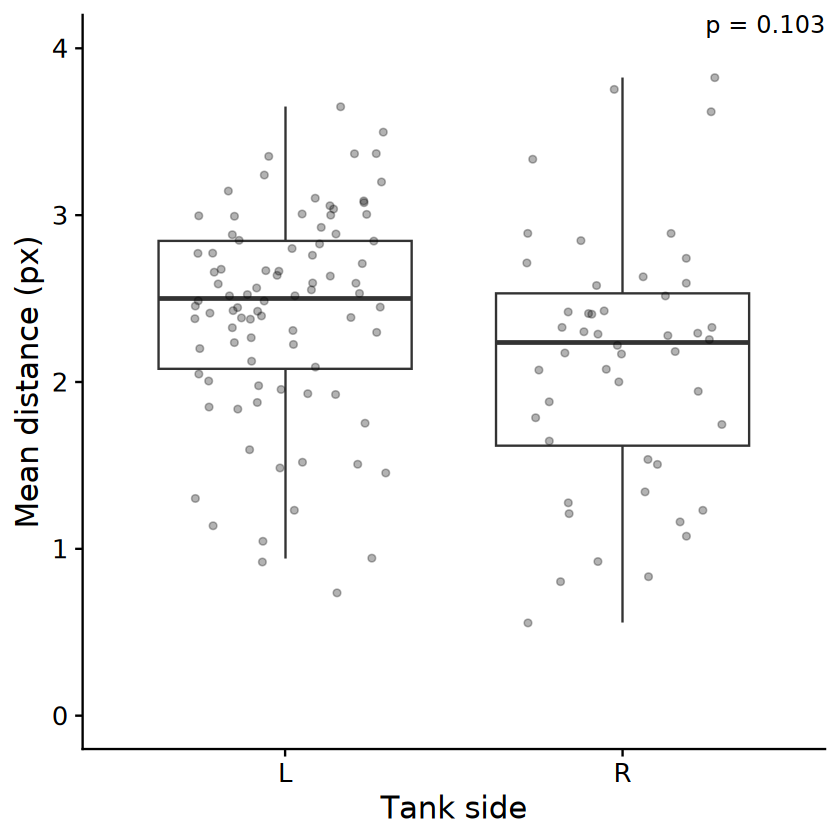

In [22]:
options(repr.plot.width = 7, repr.plot.height = 7)
p4 <- ggplot(res, aes(x = tank_side, y = speed)) +
    geom_boxplot(outlier.shape =  NA) +
    geom_jitter(width = 0.3, height = 0, alpha = 0.3) + 
    theme_cowplot(18) +
    labs(x = "Tank side", y = "Mean distance (px)") +
    geom_text(data = anova_pvals[term == "tank_side"], aes(label = p_final, x = Inf, y = Inf, hjust = 1, vjust = 1), size = 5) +
    ylim(0, 4)
p4

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


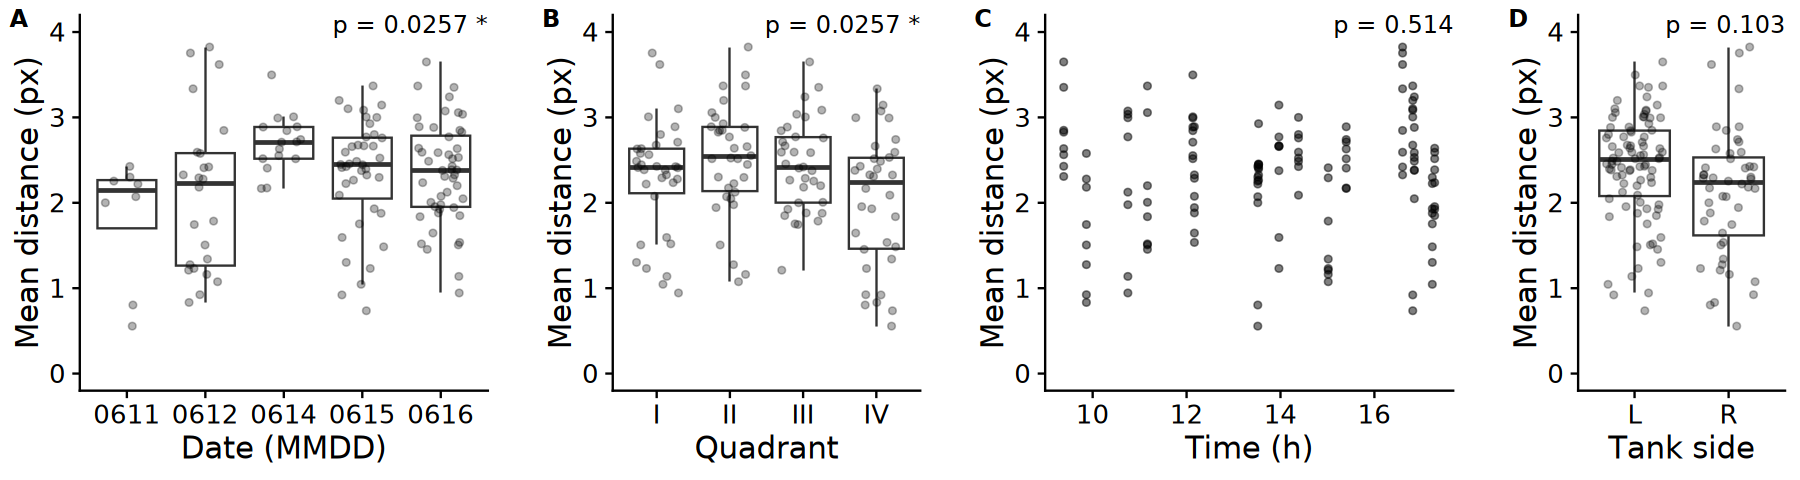

In [30]:
options(repr.plot.width = 15, repr.plot.height = 4)
p <- plot_grid(
    p1, NULL, p2, NULL, p3, NULL, p4,
    align = "v",
    axis = "tb",
    nrow = 1,
    rel_widths = c(5, 0.3, 4, 0.3, 5, 0.3, 3),
    labels = c("A", NA, "B", NA, "C", NA, "D")
)
p

In [31]:
ggsave("fig2.pdf", p, width = 15, height = 4)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_text()`).”


# Covariate effect %

In [41]:
tmp <- df[, .(d_mean = mean(distance)), by = quadrant][order(d_mean)]
(tmp[4, d_mean] - tmp[1, d_mean])/df[, mean(distance)]

[1] 0.2121374

In [44]:
tmp <- df[, .(d_mean = mean(distance)), by = date][order(d_mean)]
(tmp[5, d_mean] - tmp[1, d_mean])/df[, mean(distance)]

[1] 0.3775271

In [43]:
tmp

date,d_mean
<chr>,<dbl>
20190611,1.828846
20190612,2.104451
20190615,2.329802
20190616,2.351061
20190614,2.701529
